# Binary Classification with a Bank Dataset

**Competition**: https://www.kaggle.com/competitions/playground-series-s5e8/overview

**Goal**:<br>
Our goal is to predict whether a client will subscribe to a bank term deposit. Main metric - ROC AUC.

**Data Description**:
- `age`: Age of the client (numeric)
- `job`: Type of job (categorical: "admin.", "blue-collar", "entrepreneur", etc.)
- `marital`: Marital status (categorical: "married", "single", "divorced")
- `education`: Level of education (categorical: "primary", "secondary", "tertiary", "unknown")
- `default`: Has credit in default? (categorical: "yes", "no")
- `balance`: Average yearly balance in euros (numeric)
- `housing`: Has a housing loan? (categorical: "yes", "no")
- `loan`: Has a personal loan? (categorical: "yes", "no")
- `contact`: Type of communication contact (categorical: "unknown", "telephone", "cellular")
- `day`: Last contact day of the month (numeric, 1-31)
- `month`: Last contact month of the year (categorical: "jan", "feb", "mar", …, "dec")
- `duration`: Last contact duration in seconds (numeric)
- `campaign`: Number of contacts performed during this campaign (numeric)
- `pdays`: Number of days since the client was last contacted from a previous campaign (numeric; -1 means the client was not - previously contacted)
- `previous`: Number of contacts performed before this campaign (numeric)
- `poutcome`: Outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success")
- `y`: The target variable, whether the client subscribed to a term deposit (binary: "yes", "no")

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Загрузка и просмотр данных

In [2]:
!pip install phik
!pip install lightgbm

!pip install -U "scikit-learn==1.4.2" "lightgbm==4.3.0"

In [3]:
# === Импорты и настройки ===================================================
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix
from phik.report import plot_correlation_matrix
from scipy.stats import chi2_contingency
import scipy.stats as st

# Настройка pandas для отображения полного текста
pd.set_option('display.max_colwidth', None)

# Задаем стиль графиков
sns.set(style="whitegrid")

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid, cross_validate, ParameterSampler
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

from tqdm.auto import tqdm

RANDOM_STATE = 42

In [4]:
# === Параметры окружения ====================================================
TRAIN_PATH = "/kaggle/input/playground-series-s5e8/train.csv"
TEST_PATH  = "/kaggle/input/playground-series-s5e8/test.csv"

# Локально можно заменить на "train.csv" и "test.csv"
if not os.path.exists(TRAIN_PATH):
    TRAIN_PATH = "train.csv"
if not os.path.exists(TEST_PATH):
    TEST_PATH = "test.csv"

# === Загрузка данных ========================================================
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("train.shape:", train.shape)
print("test.shape :", test.shape)
print("\nПервые строки train:")
display(train.head())
display(train.info())

train.shape: (750000, 18)
test.shape : (250000, 17)

Первые строки train:


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


None

## Предобработка данных

In [5]:
# Определяет пропущенные значения
def analyze_missing_values(df):
    total = len(df)
    missing_counts = df.isna().sum()
    missing_percent = (missing_counts / total * 100).round(2)
    
    missing = pd.DataFrame({
        'Пропущено': missing_counts,
        '% от общего': missing_percent
    })
    missing = missing[missing['Пропущено'] > 0]
    
    if missing.empty:
        print("Пропущенные значения отсутствуют.")
    else:
        print("Число пропусков по столбцам:")
        display(missing)

analyze_missing_values(train)
analyze_missing_values(test)

Пропущенные значения отсутствуют.
Пропущенные значения отсутствуют.


In [6]:
def analyze_duplicates(df, subset=None):
    # Маска дубликатов (все, кроме первого вхождения)
    duplicate_mask = df.duplicated(subset=subset, keep='first')
    
    if not duplicate_mask.any():
        print("Дубликаты отсутствуют.")
        return
    
    col_info = f"по столбцам: {subset}" if subset else "по всем столбцам"
    print(f"Найдено дубликатов ({col_info}): {duplicate_mask.sum()}")

    # Получаем все строки-дубликаты и их первые оригиналы
    duplicates = df[duplicate_mask]
    first_occurrences = df[df.duplicated(subset=subset, keep='last')]

    # Объединяем для сравнения
    combined = pd.concat([first_occurrences, duplicates]).sort_index()
    
    display(combined)

analyze_duplicates(train)
analyze_duplicates(test)

Дубликаты отсутствуют.
Дубликаты отсутствуют.


Дополнительная предобработка на данном этапе не требуется.

## EDA

### Распределения признаков

In [7]:
def explore_dataframe(df, name):
    print(f'--- Анализ таблицы: {name} ---\n')

    df = df.drop(columns=['id'], errors='ignore')

    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    discrete_cols = [
        col for col in numeric_cols
        if pd.api.types.is_integer_dtype(df[col]) and df[col].nunique() <= 50
    ]
    continuous_cols = [col for col in numeric_cols if col not in discrete_cols]

    print('Числовые признаки:\n')
    display(df[numeric_cols].describe().T)
    print()

    if categorical_cols:
        print('Категориальные признаки:\n')
        cat_stats = []
        for col in categorical_cols:
            mode_val = df[col].mode()[0] if not df[col].mode().empty else None
            cat_stats.append({
                'Признак': col,
                'Уникальных значений': df[col].nunique(),
                'Мода': mode_val
            })
        display(pd.DataFrame(cat_stats))
        print()

    def plot_distributions(cols, plot_type, title):
        n = len(cols)
        cols_per_row = 2
        rows = (n + cols_per_row - 1) // cols_per_row
        fig, axes = plt.subplots(rows, cols_per_row, figsize=(14, 5 * rows))
        axes = axes.flatten()

        for i, col in enumerate(cols):
            if plot_type == 'numeric':
                sns.histplot(df[col], kde=True, ax=axes[i])
            else:
                counts = df[col].value_counts().sort_values(ascending=False)
                if len(counts) > 13:
                    counts = counts.head(12)
                sns.barplot(x=counts.index.astype(str), y=counts.values, ax=axes[i])
                axes[i].tick_params(axis='x', rotation=45)
            axes[i].set_title(col)

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        fig.suptitle(f'{title} ({name})', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

    if continuous_cols:
        plot_distributions(continuous_cols, 'numeric', 'Распределение непрерывных числовых признаков')

    if discrete_cols or categorical_cols:
        plot_distributions(discrete_cols + categorical_cols, 'categorical', 'Распределение дискретных и категориальных признаков')

--- Анализ таблицы: Train df ---

Числовые признаки:



,count,mean,std,min,25%,50%,75%,max
age,750000.0,40.926395,10.098829,18.0,33.0,39.0,48.0,95.0
balance,750000.0,1204.067397,2836.096759,-8019.0,0.0,634.0,1390.0,99717.0
day,750000.0,16.117209,8.250832,1.0,9.0,17.0,21.0,31.0
duration,750000.0,256.229144,272.555662,1.0,91.0,133.0,361.0,4918.0
campaign,750000.0,2.577008,2.718514,1.0,1.0,2.0,3.0,63.0
pdays,750000.0,22.412733,77.319998,-1.0,-1.0,-1.0,-1.0,871.0
previous,750000.0,0.298545,1.335926,0.0,0.0,0.0,0.0,200.0
y,750000.0,0.120651,0.325721,0.0,0.0,0.0,0.0,1.0



Категориальные признаки:



,Признак,Уникальных значений,Мода
0,job,12,management
1,marital,3,married
2,education,4,secondary
3,default,2,no
4,housing,2,yes
5,loan,2,no
6,contact,3,cellular
7,month,12,may
8,poutcome,4,unknown


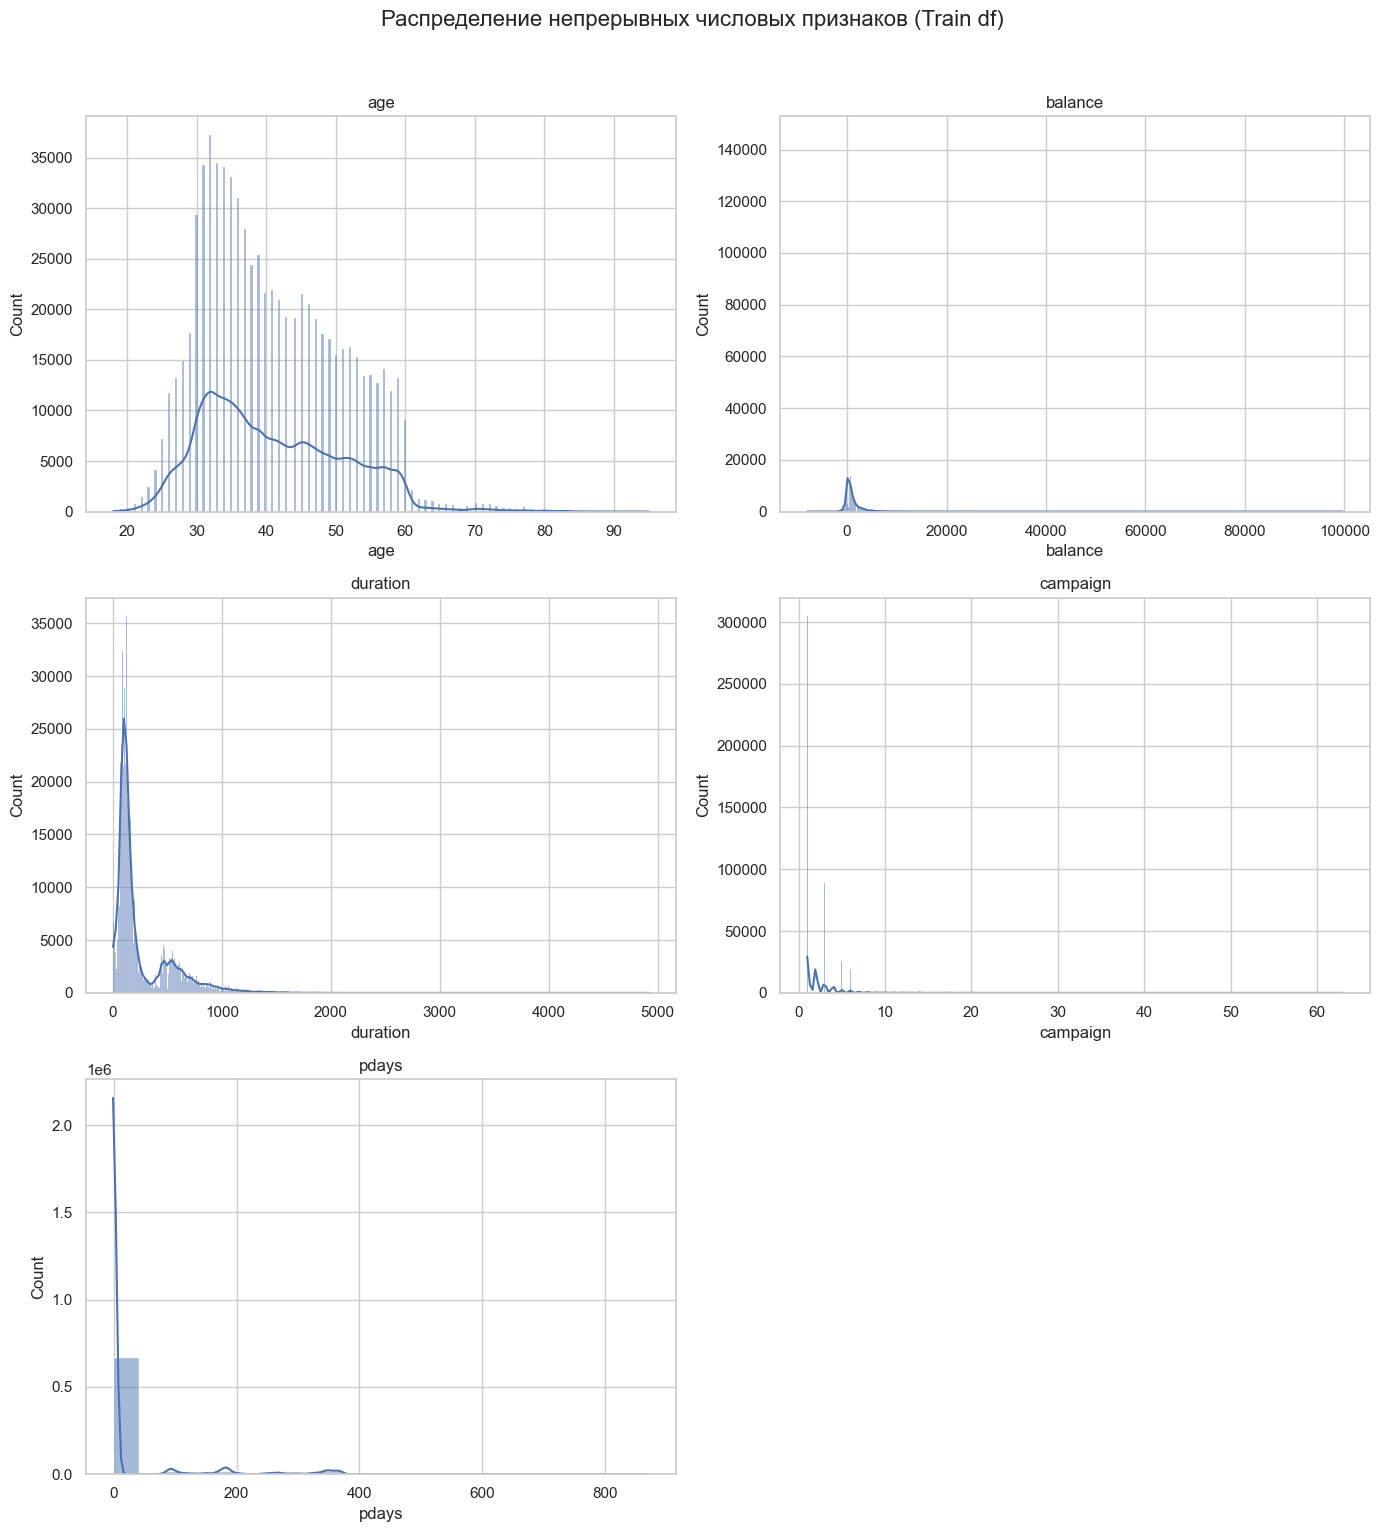

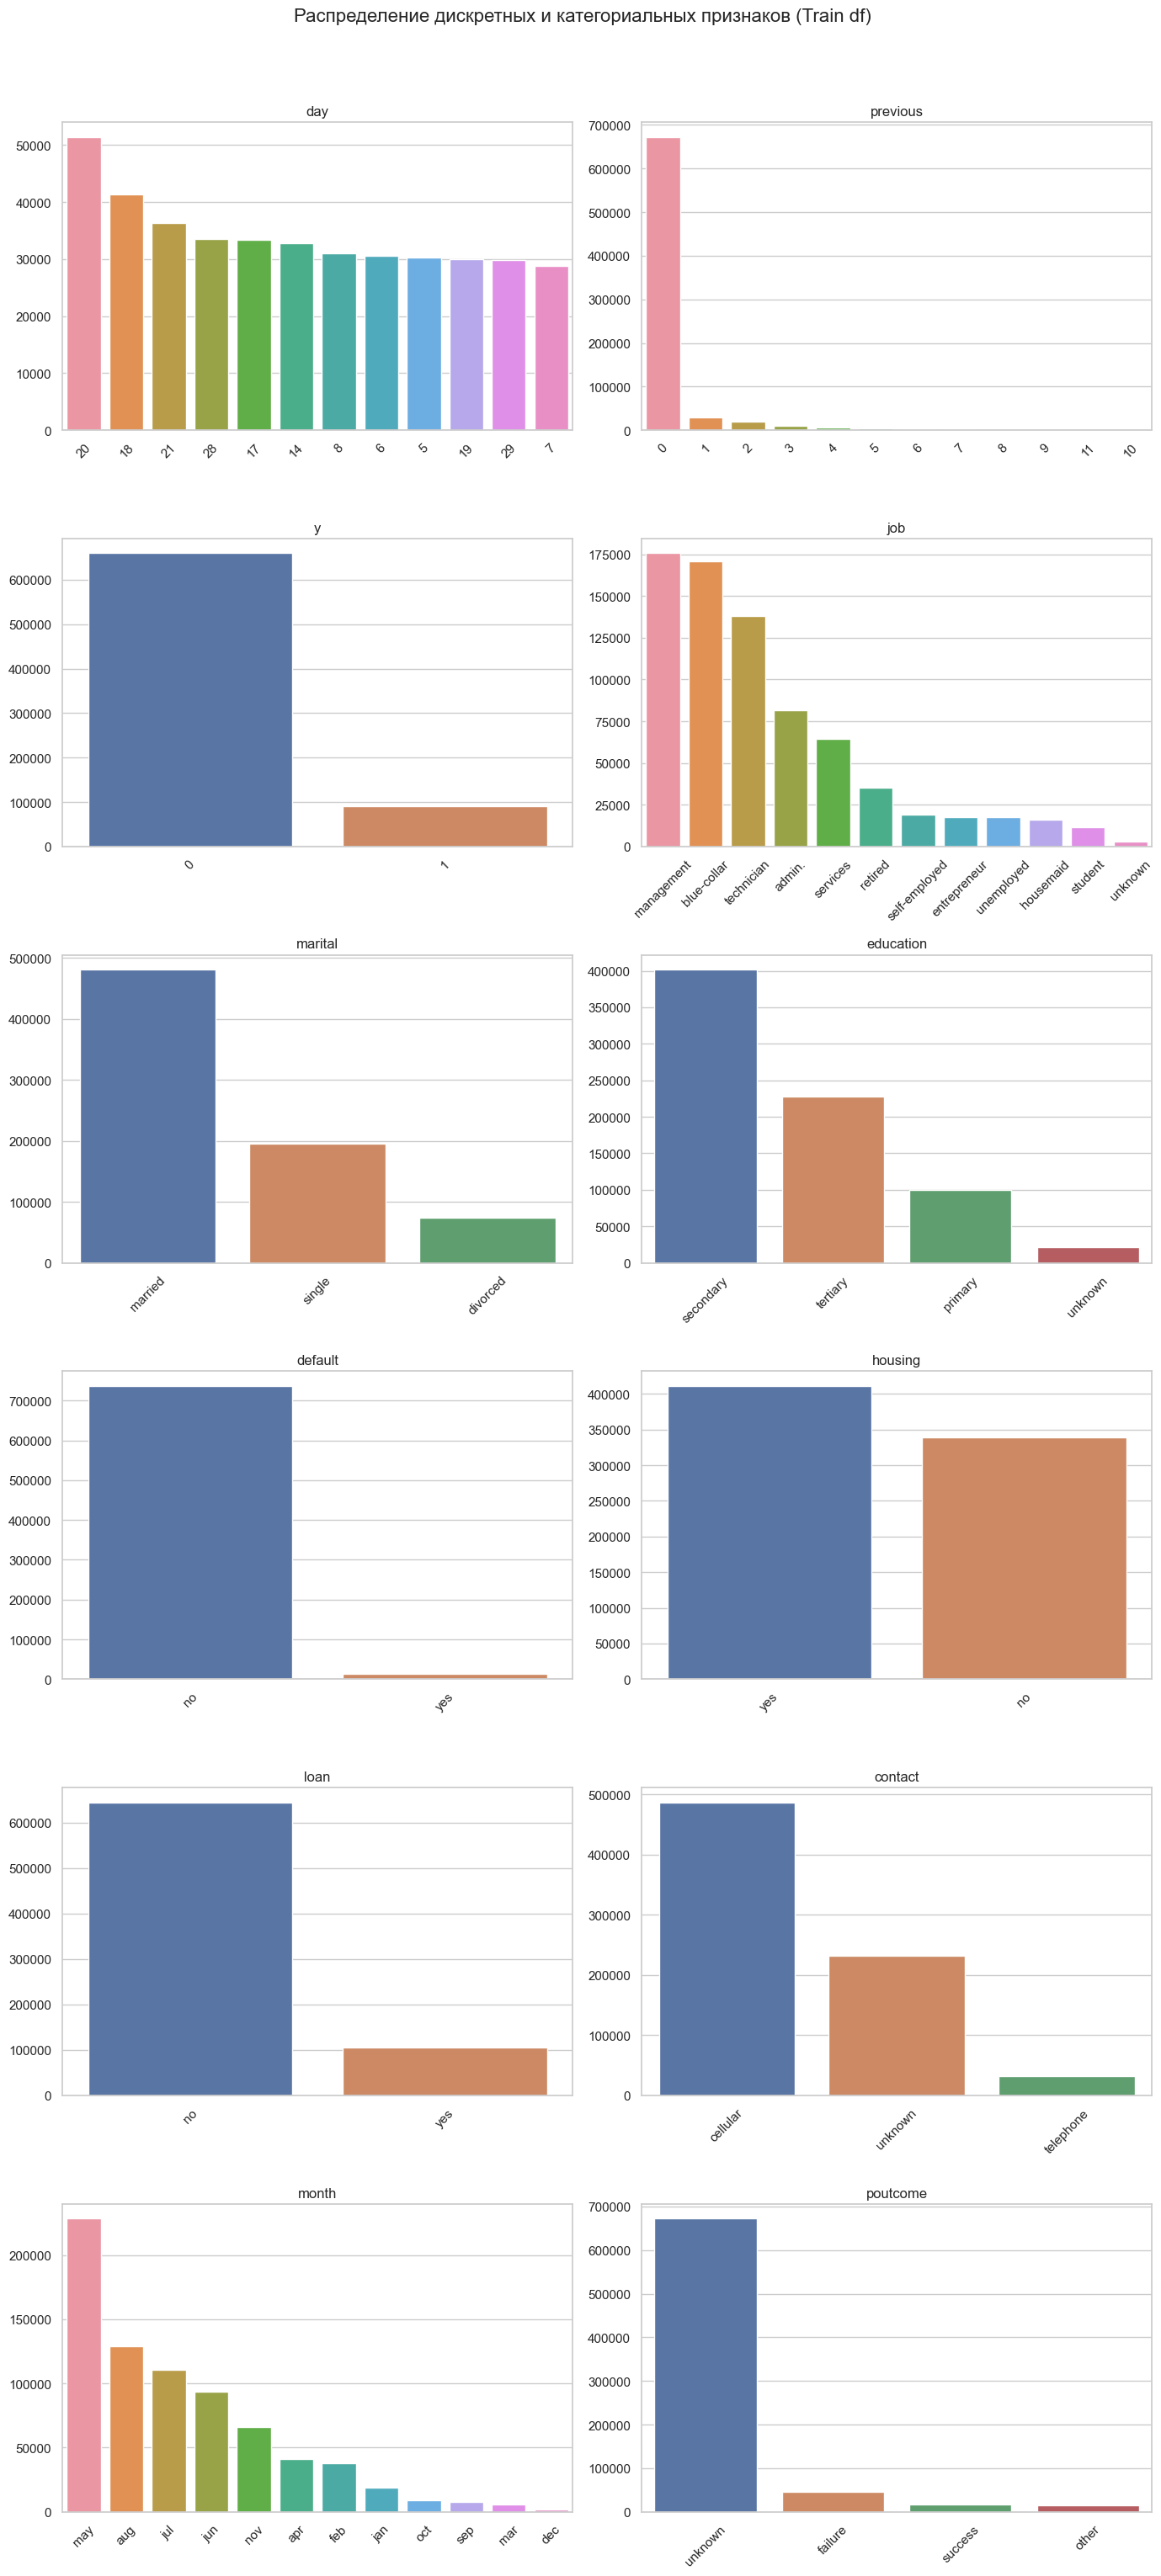

In [8]:
explore_dataframe(train, "Train df")

--- Анализ таблицы: Test df ---

Числовые признаки:



,count,mean,std,min,25%,50%,75%,max
age,250000.0,40.932332,10.081613,18.0,33.0,39.0,48.0,95.0
balance,250000.0,1197.426352,2741.520699,-8019.0,0.0,631.0,1389.0,98517.0
day,250000.0,16.116068,8.258509,1.0,9.0,17.0,21.0,31.0
duration,250000.0,255.342260,271.404326,3.0,91.0,133.0,353.0,4918.0
campaign,250000.0,2.573548,2.709661,1.0,1.0,2.0,3.0,58.0
pdays,250000.0,22.280028,76.915879,-1.0,-1.0,-1.0,-1.0,871.0
previous,250000.0,0.303728,1.384574,0.0,0.0,0.0,0.0,150.0



Категориальные признаки:



,Признак,Уникальных значений,Мода
0,job,12,management
1,marital,3,married
2,education,4,secondary
3,default,2,no
4,housing,2,yes
5,loan,2,no
6,contact,3,cellular
7,month,12,may
8,poutcome,4,unknown


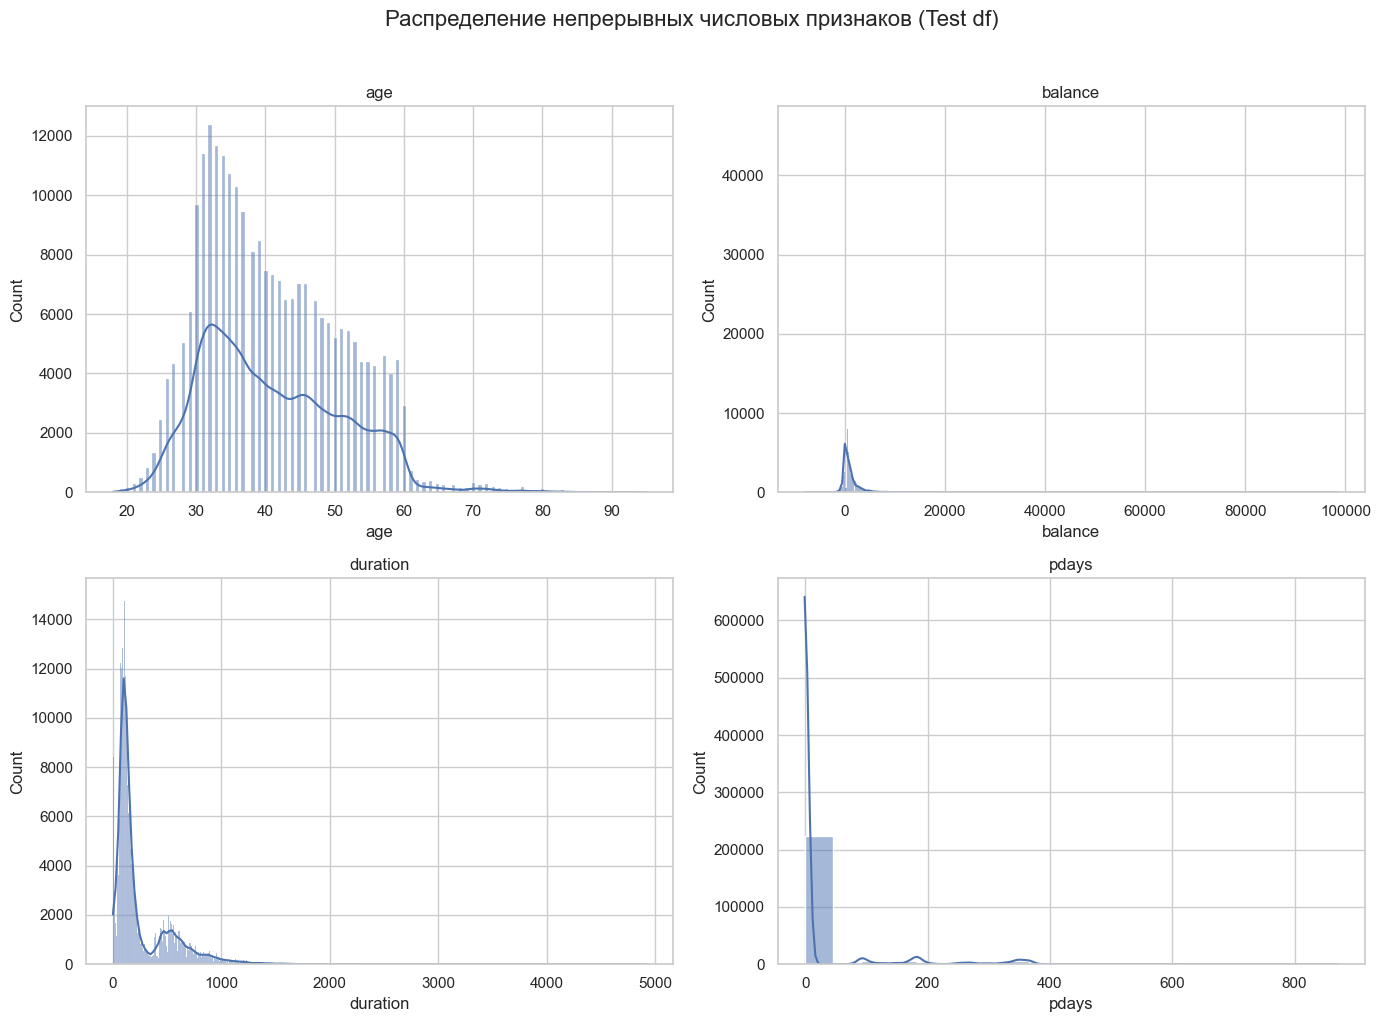

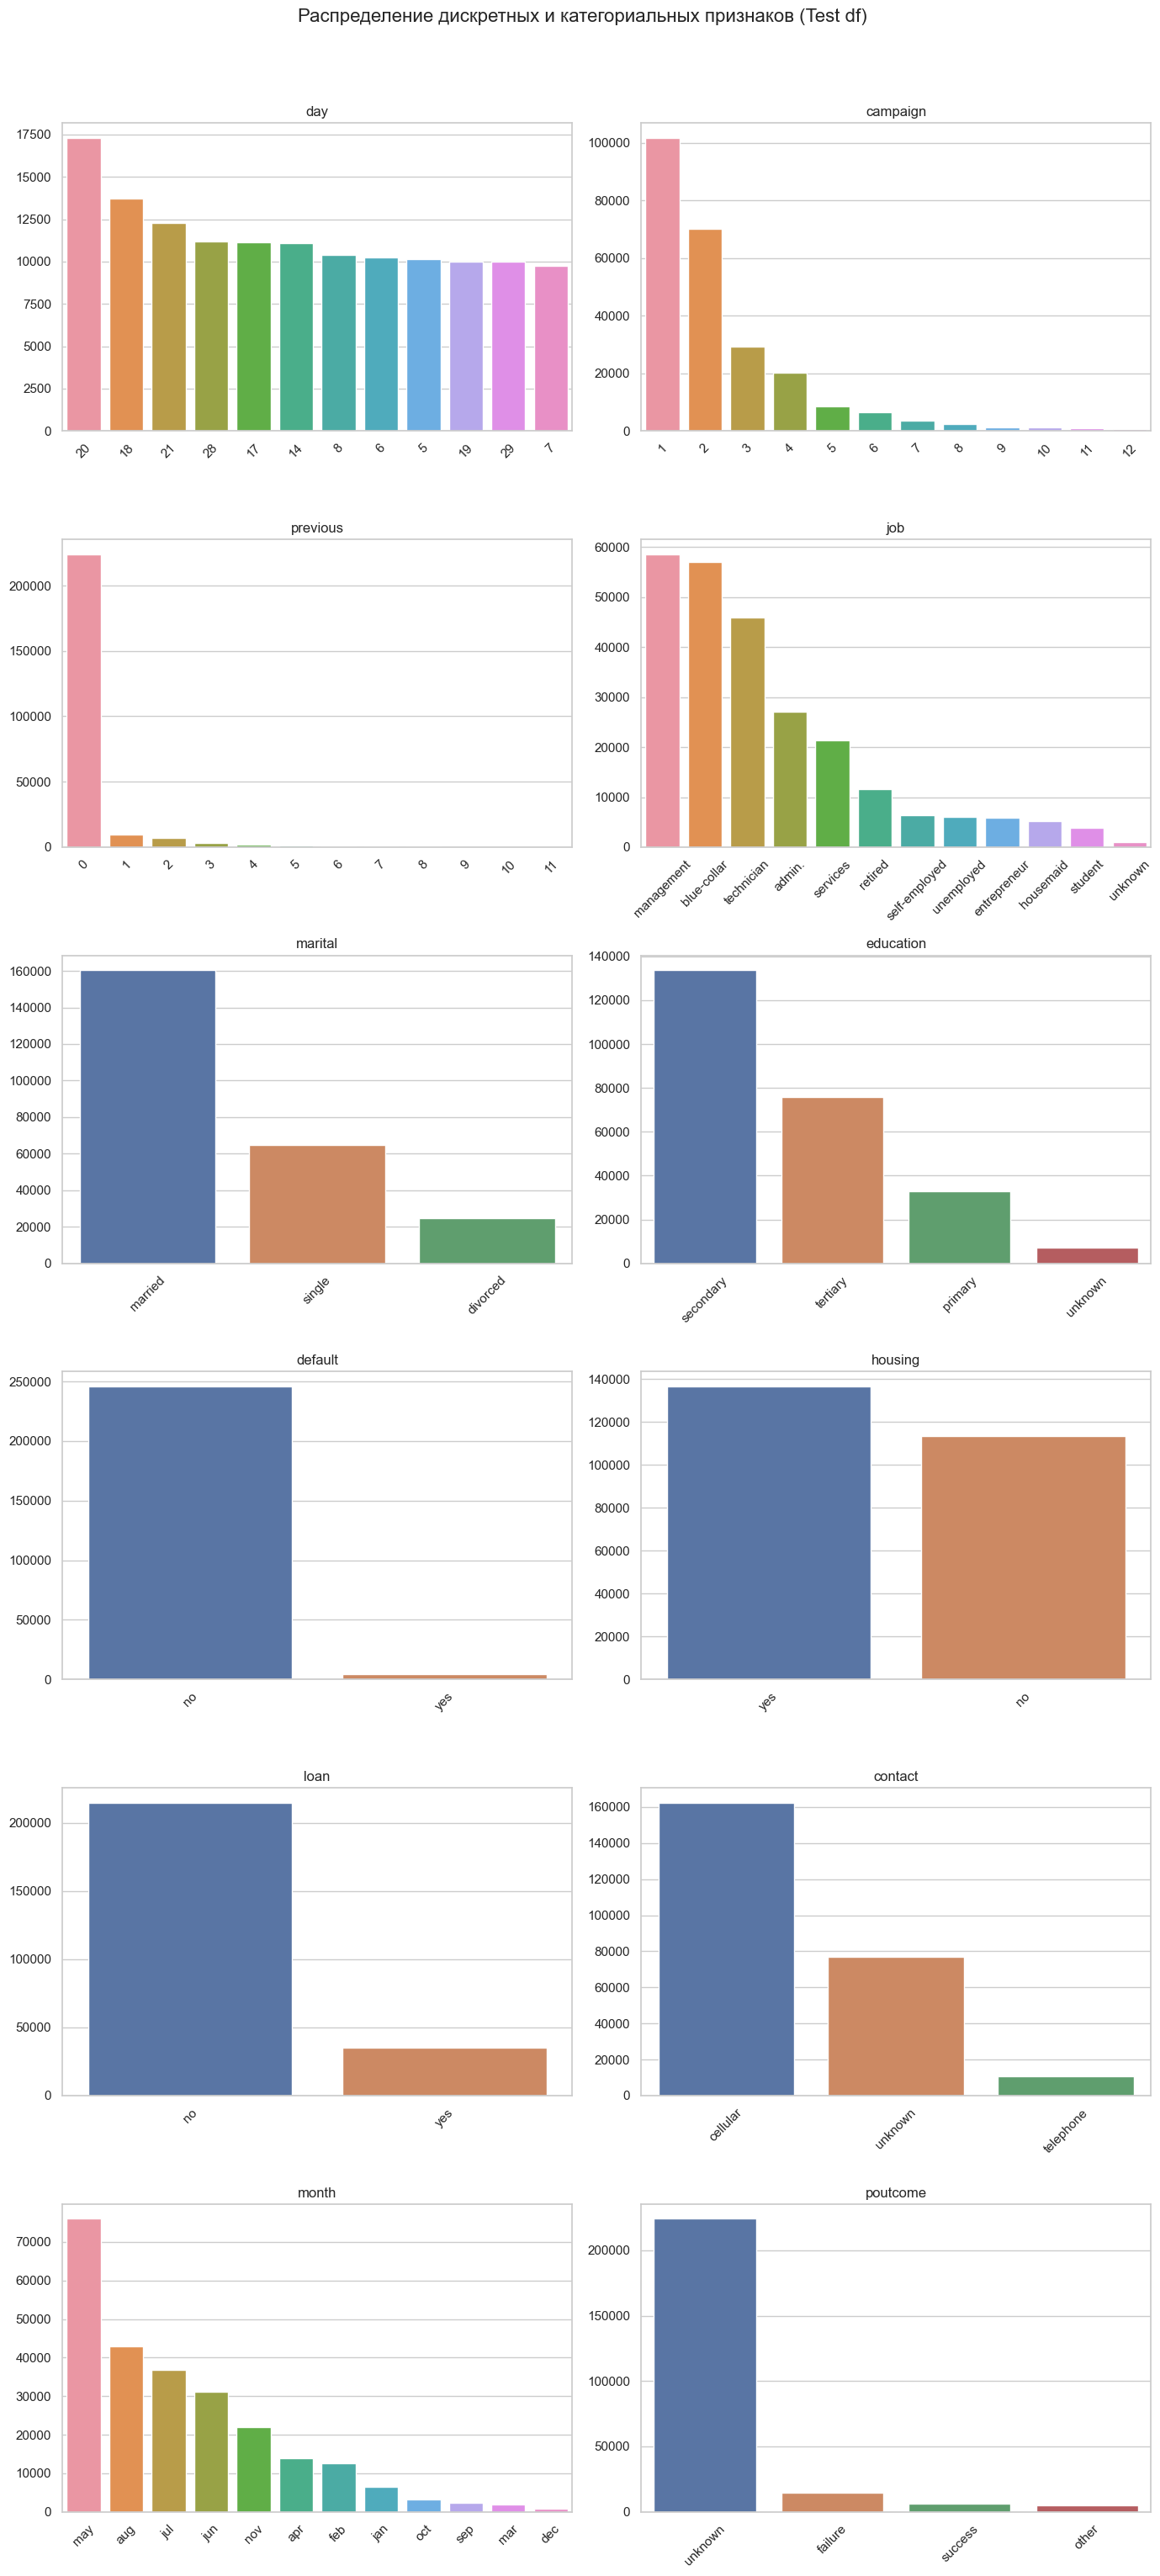

In [9]:
explore_dataframe(test, "Test df")

Между train и test нет data drift – распределения признаков практически совпадают.

### Оценка корреляций

In [10]:
# Строит графики корреляций (Bank Marketing)
def plot_feature_correlations(df, target='y'):
    # --- числовые: берём только числовые + цель; исключается id
    numeric_cols = [c for c in df.select_dtypes(include=['int64', 'float64']).columns
                    if c != 'id' and c in df.columns]
    if target in df.columns and target not in numeric_cols and np.issubdtype(df[target].dtype, np.number):
        numeric_cols = [target] + numeric_cols
    else:
        # гарантируем, что цель первая
        numeric_cols = [target] + [c for c in numeric_cols if c != target]

    # --- Спирмен для числовых ---
    if len(numeric_cols) > 1:
        corr_spearman = df[numeric_cols].corr(method='spearman')
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap='coolwarm',
                    square=True, cbar_kws={"shrink": .75})
        plt.title("Корреляция Спирмена: числовые признаки")
        plt.tight_layout()
        plt.show()
    else:
        print("Недостаточно числовых признаков для корреляции.")

    # --- категориальные: φ_k (или Cramér’s V при отсутствии phik) ---
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    # ограничение по числу уровней, чтобы график был читабельным
    cat_cols = [c for c in cat_cols if c in df.columns and df[c].nunique() < 100]

    try:
        # вариант с phik
        phik_corr = df[[target] + cat_cols].phik_matrix(
            interval_cols=[target] if np.issubdtype(df[target].dtype, np.number) else []
        )
        plt.figure(figsize=(10, 8))
        sns.heatmap(phik_corr[[target]].drop(target), annot=True, fmt=".2f",
                    cmap='YlGnBu', cbar_kws={"shrink": .75})
        plt.title("Phi_k-корреляция с целевой переменной")
        plt.tight_layout()
        plt.show()
    except Exception:
        # fallback: Cramér’s V (для бинарной цели работает корректно)
        def cramers_v_corrected(conf):
            chi2, _, _, _ = chi2_contingency(conf, correction=False)
            n = conf.values.sum()
            phi2 = chi2 / n
            r, k = conf.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            denom = min((kcorr-1), (rcorr-1))
            return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

        vals = []
        for c in cat_cols:
            conf = pd.crosstab(df[c], df[target])
            vals.append((c, cramers_v_corrected(conf)))
        cm = pd.DataFrame(vals, columns=['feature', 'cramers_v']).set_index('feature').sort_values('cramers_v', ascending=False)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt=".2f", cmap='YlGnBu', cbar_kws={"shrink": .75})
        plt.title("Cramér’s V с целевой переменной (fallback)")
        plt.tight_layout()
        plt.show()

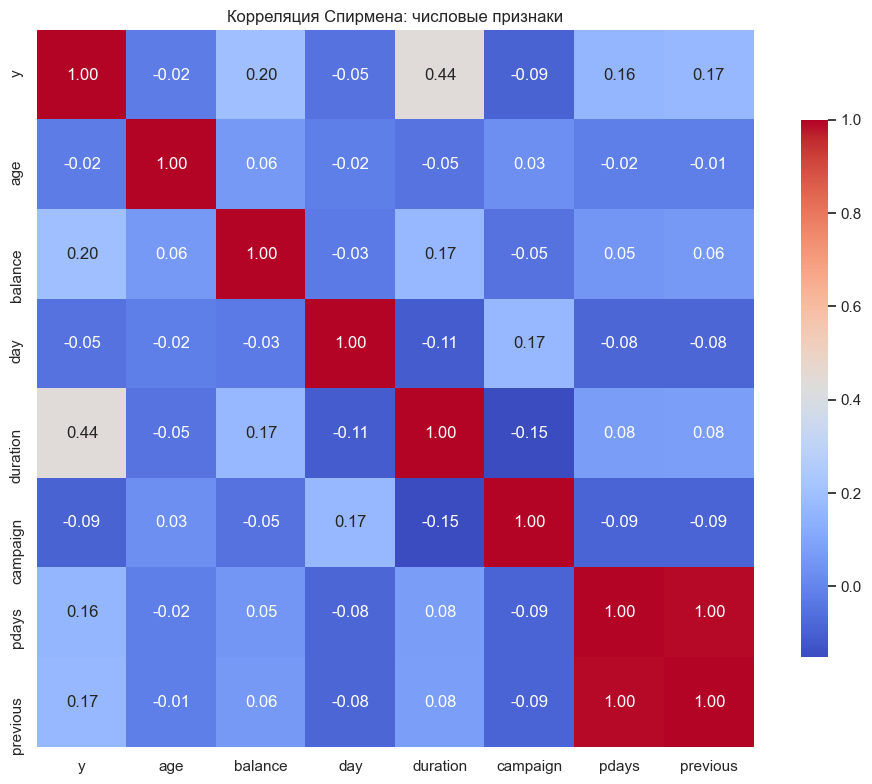

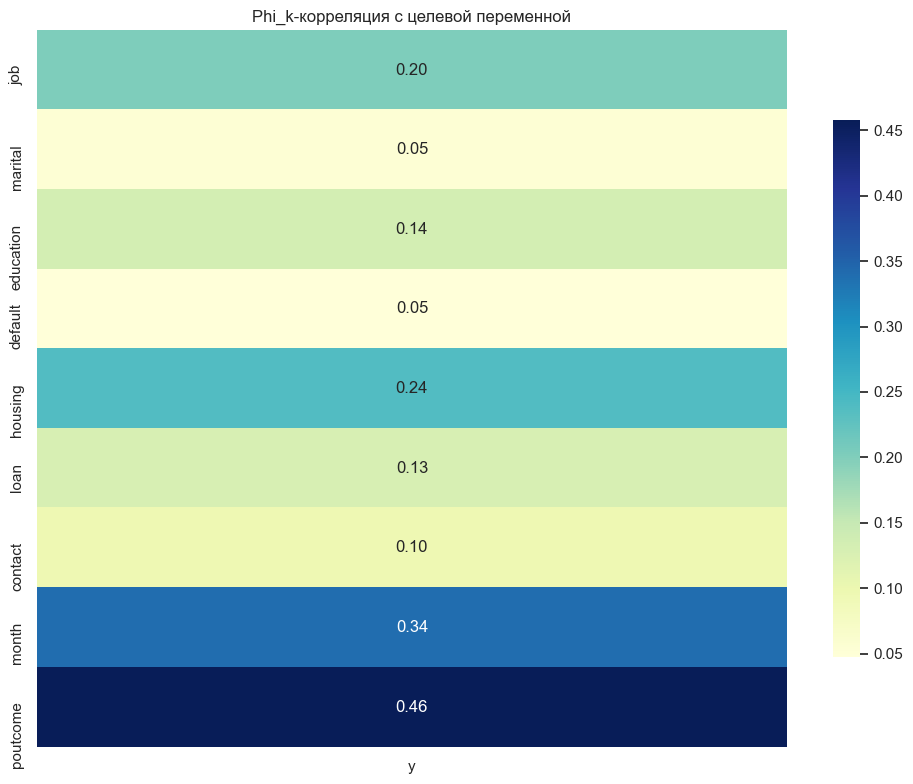

In [11]:
plot_feature_correlations(train, target='y')

Обнаружена сильная мультиколлинеарность между `pdays` и `previous` (Spearman ≈ 1.00). Это отражает бизнес-правило кампаний: при отсутствии предыдущего контакта (`previous = 0`) число дней с момента контакта кодируется как `pdays = -1`. Чтобы избежать переобучения и нестабильности коэффициентов, из пары оставляется один информативный признак. Сохранён `pdays` как более содержательный по смыслу (даёт сигнал давности контакта); избыточный `previous` будет удалён.

**Общий вывод по EDA**

**Данные**: train 750 000×18, test 250 000×17. Пропусков и явных дублей не обнаружено. Типы столбцов согласованы с бизнес-смыслом: числовые признаки age, balance, day, duration, campaign, pdays, previous; категориальные job, marital, education, default, housing, loan, contact, month, poutcome; целевая переменная y бинарная.

**Распределения.** В числовых признаках выражены тяжёлые хвосты: balance с отрицательными значениями и длинным правым хвостом; duration с длинным правым хвостом; campaign имеет редкие большие значения. Возраст находится в диапазоне 18–95 без аномалий. Для pdays доминирует значение −1, что соответствует отсутствию предыдущего контакта. Целевая переменная несбалансирована: доля положительного класса ≈12 %.

Категориальные признаки распределены реалистично: married и secondary преобладают; по month выражен пик в мае; в poutcome доля unknown высокая. Сравнение train и test показало совпадение распределений как для числовых, так и для категориальных признаков; признаков сдвига между выборками не выявлено.

**Корреляции.** Наибольшая связь с целью у duration (ранговая корреляция заметно выше, чем у остальных числовых), что подтверждает её высокую предиктивность для отклика. Среди категориальных наиболее информативны poutcome и month. Обнаружена почти идеальная мультиколлинеарность между pdays и previous, отражающая правило кодирования «previous=0 == pdays=−1». Для устойчивости модели принято решение устранять избыточность: использовать декомпозицию pdays -> бинарный индикатор факта прошлого контакта (was_contacted) и неотрицательный лаг pdays_pos, а исходный previous исключать на этапе подготовки данных.

**Вывод для подготовки и моделирования.** Для деревьев масштабирование не требуется; тяжёлые хвосты будут дополнительно учтены инженерными преобразованиями (лог-трансформации и биннинг в пайплайне). Переменные day и campaign трактуются как категориальные. Кодирование категориальных выполняется через OHE с игнорированием невиданных уровней. Основная метрика – ROC AUC. По базовым испытаниям лучшее качество показывает LGBM; дальнейшая настройка гиперпараметров и умеренный инжиниринг признаков направлены на повышение AUC без риска утечки и при сохранении воспроизводимости через единый sklearn-пайплайн.

## Обучение моделей

**UPDATE**

1. Оставил только **LGBM**, т.к. лучший на CV. 

2. Признаки:
- Разложение `pdays` -> `was_contacted` (бинарный индикатор) и `pdays_pos` (давность контакта, `clip ≥ 0`). Это снимает мультиколлинеарность с `previous` и разделяет «факт контакта» и «сколько дней прошло».
- `day`, `campaign` теперь категориальные (строки) -> идут в OHE. Это лучше моделирует их дискретную нелинейную природу.
- Инженерные признаки (обоснование в скобках):
    - `balance_log_signed` = sign(balance)·log1p(|balance|) (стабилизация тяжёлых хвостов);
    - `duration_log` (то же для duration);
    - `duration_bin` квантильные бины (ступенчатые эффекты, деревьям удобно);
    - `age_bin` возрастные интервалы (типовые пороги по возрасту);
    - `campaign_cap` = min(campaign, 6) (отрезаем редкий длинный хвост);
    - `month_sin`, `month_cos` (сезонность месяца);
    - `day_sin`, `day_cos` (календарный паттерн по дню).
- Убрал масштабирование числовых для бустинговых деревьев — не нужно деревьям, ускоряет пайплайн.

3. Перешел на рандомизированный поиск на gpu + early stopping.

In [12]:
# ===== Разделим X, y (без id/previous удаление сделаем в препроцессоре) =====
X_train = train.drop(columns=["y"]).copy()
y_train = train["y"].astype(int).values

In [13]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    """
    Инжиниринг фич до приведения типов:
    - balance_log_signed
    - duration_log
    - duration_bin (квантильные бины)
    - age_bin (фиксированные бины)
    - campaign_cap = min(campaign, 6)
    - month_sin/cos (month: str -> 1..12)
    - day_sin/cos  (day: 1..31)
    """
    def __init__(self, duration_bins=5):
        self.duration_bins = duration_bins
        self.duration_edges_ = None
        # маппинг месяцев
        self._month_map = {
            'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,
            'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12
        }

    def fit(self, X, y=None):
        X = X.copy()
        # квантильные бины для duration (по train)
        if "duration" in X.columns:
            self.duration_edges_ = np.unique(
                np.quantile(X["duration"].values, 
                            q=np.linspace(0, 1, self.duration_bins+1))
            )
            # защитимся от совпадений квантилей
            if len(self.duration_edges_) <= 2:
                self.duration_edges_ = None
        return self

    def transform(self, X):
        X = X.copy()

        # balance_log_signed
        if "balance" in X.columns:
            X["balance_log_signed"] = np.sign(X["balance"]) * np.log1p(np.abs(X["balance"]))

        # duration_log + duration_bin
        if "duration" in X.columns:
            X["duration_log"] = np.log1p(X["duration"])
            if self.duration_edges_ is not None and len(self.duration_edges_) > 2:
                # pd.cut с заранее выученными границами
                X["duration_bin"] = pd.cut(
                    X["duration"],
                    bins=self.duration_edges_,
                    include_lowest=True,
                    duplicates="drop"
                ).astype(str)
            else:
                X["duration_bin"] = pd.qcut(X["duration"], q=5, duplicates="drop").astype(str)

        # age_bin
        if "age" in X.columns:
            X["age_bin"] = pd.cut(
                X["age"],
                bins=[17, 25, 35, 45, 60, 120],
                labels=["18-25","26-35","36-45","46-60","60+"],
                include_lowest=True
            ).astype(str)

        # campaign_cap
        if "campaign" in X.columns:
            X["campaign_cap"] = np.minimum(X["campaign"], 6)

        # month_sin/cos
        if "month" in X.columns:
            mnum = pd.Series(X["month"]).map(self._month_map).fillna(0).astype(int)
            X["month_sin"] = np.sin(2*np.pi * mnum / 12)
            X["month_cos"] = np.cos(2*np.pi * mnum / 12)

        # day_sin/cos
        if "day" in X.columns:
            day_num = pd.to_numeric(X["day"], errors="coerce").fillna(0).astype(int)
            X["day_sin"] = np.sin(2*np.pi * day_num / 31)
            X["day_cos"] = np.cos(2*np.pi * day_num / 31)

        return X


class PdaysTransformer(BaseEstimator, TransformerMixin):
    """
    - создаёт was_contacted = (pdays != -1).astype(int)
    - создаёт pdays_pos = clip(pdays, 0, None)
    - удаляет 'pdays' и 'previous'
    - приводит day и campaign к строке (категории для OHE)
    """
    def __init__(self, cast_to_str_cols=("day", "campaign")):
        self.cast_to_str_cols = cast_to_str_cols

    def fit(self, X, y=None): 
        return self

    def transform(self, X):
        X = X.copy()
        if "pdays" in X.columns:
            X["was_contacted"] = (X["pdays"] != -1).astype(int)
            X["pdays_pos"] = X["pdays"].clip(lower=0)
            X = X.drop(columns=["pdays"])
        if "previous" in X.columns:
            X = X.drop(columns=["previous"])
        for c in self.cast_to_str_cols:
            if c in X.columns:
                X[c] = X[c].astype(str)
        return X

In [14]:
# Категориальные: исходные + инженерные биновые + was_contacted + day/campaign (каст строкой)
cat_features = [
    'job','marital','education','default','housing','loan',
    'contact','month','poutcome','day','campaign',
    'was_contacted','duration_bin','age_bin'
]

# Числовые: исходные + инженерные непрерывные + pdays_pos
num_features = [
    'age','balance','duration','pdays_pos',
    'balance_log_signed','duration_log',
    'campaign_cap','month_sin','month_cos','day_sin','day_cos'
]

In [15]:
# ===== Препроцессор =====
preprocess = Pipeline(steps=[
    ("fe", FeatureEngineeringTransformer(duration_bins=5)),
    ("pdays_block", PdaysTransformer(cast_to_str_cols=("day","campaign"))),
    ("ct", ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_features),
        ],
        remainder="drop"
    ))
])

In [16]:
# ===== Модель и пайплайны =====
pipe_lgbm = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", lgb.LGBMClassifier(
        objective="binary",
        random_state=RANDOM_STATE,
        n_jobs=8,
        device_type="gpu",
        verbosity=-1
    ))
])

# Положительный вес класса (для дисбаланса)
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
pos_weight_sqrt = float(np.sqrt(pos_weight))

In [17]:
# распределения гиперпараметров
param_dists = {
    "n_estimators": st.randint(800, 2500),
    "learning_rate": st.uniform(0.01, 0.07),
    "num_leaves": st.randint(31, 256),
    "max_depth": [-1, 8, 10, 12],
    "min_child_samples": st.randint(10, 200),
    "subsample": st.uniform(0.6, 0.4),
    "colsample_bytree": st.uniform(0.6, 0.4),
    "reg_lambda": st.uniform(0.0, 5.0),
    "reg_alpha": st.uniform(0.0, 2.0),
    "min_split_gain": st.uniform(0.0, 0.2),
    "max_bin": [255],  # GPU-совместимо
    "scale_pos_weight": [1.0, float((len(y_train)-y_train.sum())/y_train.sum())],
}

In [18]:
N_ITER = 200
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
samples = list(ParameterSampler(param_dists, n_iter=N_ITER, random_state=RANDOM_STATE))

best_auc, best_params = -np.inf, None
results = []

total_steps = N_ITER * cv.get_n_splits()
pbar = tqdm(total=total_steps, desc="LGBM random search (folds)", dynamic_ncols=True, mininterval=0.3)

for i, params in enumerate(samples, start=1):
    fold_aucs = []

    for fold, (tr_idx, val_idx) in enumerate(cv.split(X_train, y_train), start=1):
        X_tr, y_tr = X_train.iloc[tr_idx], y_train[tr_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train[val_idx]

        # препроцессор на трейне -> transform валидации
        prep = clone(preprocess)
        X_tr_proc = prep.fit_transform(X_tr, y_tr)
        X_val_proc = prep.transform(X_val)

        # LGBM на преобразованных матрицах
        clf = lgb.LGBMClassifier(
            objective="binary",
            random_state=RANDOM_STATE,
            n_jobs=8,
            device_type="gpu",
            verbosity=-1,
            **params
        )
        clf.fit(
            X_tr_proc, y_tr,
            eval_set=[(X_val_proc, y_val)],
            eval_metric="auc",
            callbacks=[
                lgb.early_stopping(200, verbose=False),
                lgb.log_evaluation(-1),
            ],
        )

        proba = clf.predict_proba(X_val_proc)[:, 1]
        auc = roc_auc_score(y_val, proba)
        fold_aucs.append(auc)

        # обновление прогресса после каждого фолда
        curr_mean = np.mean(fold_aucs)
        pbar.update(1)
        pbar.set_postfix({
            "iter": f"{i}/{N_ITER}",
            "fold": f"{fold}/5",
            "AUC_curr": f"{auc:.5f}",
            "AUC_iter_mean": f"{curr_mean:.5f}",
            "AUC_best": f"{best_auc:.5f}" if best_auc > 0 else "—",
        })

    mean_auc, std_auc = float(np.mean(fold_aucs)), float(np.std(fold_aucs))
    results.append({
        "params": params,
        "cv_auc_mean": round(mean_auc, 5),
        "cv_auc_std": round(std_auc, 5),
    })
    if mean_auc > best_auc:
        best_auc, best_params = mean_auc, params

pbar.close()

# финальный пайплайн с лучшими параметрами
best_pipeline = Pipeline(steps=[
    ("prep", clone(preprocess)),
    ("clf", lgb.LGBMClassifier(
        objective="binary",
        random_state=RANDOM_STATE,
        device_type="gpu",
        verbosity=-1,
        **best_params
    ))
])
best_pipeline.fit(X_train, y_train)

results_df = pd.DataFrame(results).sort_values("cv_auc_mean", ascending=False).reset_index(drop=True)
display(results_df.head(20))
print("Best AUC:", best_auc)
print("Best params:", best_params)

LGBM random search (folds):   0%|                                                             | 0/1000 [00:00<…

,params,cv_auc_mean,cv_auc_std
0,"{'colsample_bytree': 0.6351472444970627, 'learning_rate': 0.019717734140941426, 'max_bin': 255, 'max_depth': -1, 'min_child_samples': 26, 'min_split_gain': 0.023339212828336266, 'n_estimators': 1710, 'num_leaves': 182, 'reg_alpha': 1.2122037621116772, 'reg_lambda': 3.971447249832312, 'scale_pos_weight': 1.0, 'subsample': 0.9718116576991304}",0.96925,0.00046
1,"{'colsample_bytree': 0.9079974212394444, 'learning_rate': 0.025107471924779023, 'max_bin': 255, 'max_depth': -1, 'min_child_samples': 112, 'min_split_gain': 0.0170694929987536, 'n_estimators': 1676, 'num_leaves': 254, 'reg_alpha': 1.062709263136296, 'reg_lambda': 2.7031756080505325, 'scale_pos_weight': 1.0, 'subsample': 0.6553412369671205}",0.96909,0.00045
2,"{'colsample_bytree': 0.8471388960804855, 'learning_rate': 0.07082334891351028, 'max_bin': 255, 'max_depth': 12, 'min_child_samples': 122, 'min_split_gain': 0.0060774119393673725, 'n_estimators': 1144, 'num_leaves': 76, 'reg_alpha': 1.8373555939870085, 'reg_lambda': 3.0030477127311803, 'scale_pos_weight': 1.0, 'subsample': 0.8635541880930628}",0.96905,0.00046
3,"{'colsample_bytree': 0.9224805119172246, 'learning_rate': 0.06237817832685609, 'max_bin': 255, 'max_depth': -1, 'min_child_samples': 189, 'min_split_gain': 0.04186986466734206, 'n_estimators': 1438, 'num_leaves': 86, 'reg_alpha': 0.9690459703820427, 'reg_lambda': 3.0912738576514798, 'scale_pos_weight': 1.0, 'subsample': 0.8125063015894136}",0.96905,0.00044
4,"{'colsample_bytree': 0.6557088290653549, 'learning_rate': 0.06558176324892072, 'max_bin': 255, 'max_depth': -1, 'min_child_samples': 42, 'min_split_gain': 0.10669221839526431, 'n_estimators': 2054, 'num_leaves': 185, 'reg_alpha': 1.5771944224490615, 'reg_lambda': 0.7583743986637559, 'scale_pos_weight': 1.0, 'subsample': 0.8827921844973836}",0.96902,0.00043
5,"{'colsample_bytree': 0.6470104987108419, 'learning_rate': 0.05544472114812445, 'max_bin': 255, 'max_depth': -1, 'min_child_samples': 140, 'min_split_gain': 0.11667375301943193, 'n_estimators': 989, 'num_leaves': 221, 'reg_alpha': 0.9554297817604553, 'reg_lambda': 0.4144566084667711, 'scale_pos_weight': 1.0, 'subsample': 0.6894383354077811}",0.96902,0.00047
6,"{'colsample_bytree': 0.6731463988429229, 'learning_rate': 0.07542297981377968, 'max_bin': 255, 'max_depth': -1, 'min_child_samples': 25, 'min_split_gain': 0.10333925148531334, 'n_estimators': 1503, 'num_leaves': 221, 'reg_alpha': 0.8713457973557821, 'reg_lambda': 3.6501965828090928, 'scale_pos_weight': 1.0, 'subsample': 0.699092395800463}",0.96901,0.00047
7,"{'colsample_bytree': 0.9858081889080834, 'learning_rate': 0.06320658549066681, 'max_bin': 255, 'max_depth': -1, 'min_child_samples': 140, 'min_split_gain': 0.06239039809902609, 'n_estimators': 1369, 'num_leaves': 154, 'reg_alpha': 1.448845345228234, 'reg_lambda': 3.7291850601548218, 'scale_pos_weight': 1.0, 'subsample': 0.6124536331538045}",0.96901,0.00047
8,"{'colsample_bytree': 0.8099025726528951, 'learning_rate': 0.040236151304948106, 'max_bin': 255, 'max_depth': -1, 'min_child_samples': 68, 'min_split_gain': 0.0799721943430511, 'n_estimators': 2299, 'num_leaves': 218, 'reg_alpha': 0.7327236865873834, 'reg_lambda': 2.28034992108518, 'scale_pos_weight': 1.0, 'subsample': 0.8473544037332349}",0.96899,0.00047
9,"{'colsample_bytree': 0.8570303875788758, 'learning_rate': 0.06315410295460062, 'max_bin': 255, 'max_depth': -1, 'min_child_samples': 12, 'min_split_gain': 0.10847273299594767, 'n_estimators': 1127, 'num_leaves': 78, 'reg_alpha': 1.6943347227451484, 'reg_lambda': 4.57118257975735, 'scale_pos_weight': 1.0, 'subsample': 0.7364991310504625}",0.96899,0.00046


Best AUC: 0.9692538416241874
Best params: {'colsample_bytree': 0.6351472444970627, 'learning_rate': 0.019717734140941426, 'max_bin': 255, 'max_depth': -1, 'min_child_samples': 26, 'min_split_gain': 0.023339212828336266, 'n_estimators': 1710, 'num_leaves': 182, 'reg_alpha': 1.2122037621116772, 'reg_lambda': 3.971447249832312, 'scale_pos_weight': 1.0, 'subsample': 0.9718116576991304}


- Настройка: рандомизированный поиск (N=1000) по осмысленным распределениям гиперпараметров с 5-fold Stratified CV, ранней остановкой на валидации каждого фолда (ES=200) и GPU-обучением (max_bin=255). Препроцессинг единый пайплайном: декомпозиция `pdays -> was_contacted + pdays_pos`, перевод `day`/`campaign` в категориальные, OHE, инженерные признаки (`balance_log_signed`, `duration_log`, `duration_bin`, `age_bin`, `campaign_cap`, циклические кодировки `month_sin/cos`, `day_sin/cos`).

- Лучший результат CV: ROC AUC = 0.96925 ± 0.00046 (по 5 фолдам). Это заметно выше стартовой итерации (≈0.964–0.965).

- Лучшие гиперпараметры:
    - `n_estimators=1710`, `learning_rate≈0.0197` – «длинное» обучение с малым шагом;
    - `num_leaves=182`, `max_depth=-1` – умеренно высокая модельная сложность;
    - `min_child_samples=26`, `min_split_gain≈0.023` – контроль переобучения на уровне узлов;
    - регуляризация: `reg_lambda≈3.97`, `reg_alpha≈1.21`;
    - сэмплирование: `subsample≈0.972`, `colsample_bytree≈0.635`;
    - `scale_pos_weight=1.0` – явная балансировка не потребовалась (модель справляется сама);
    - `max_bin=255` – совместимо с GPU.
- Интерпретация:
    - Прирост AUC дал совокупный эффект: инженерные признаки для хвостов и календарики + тщательная настройка `num_leaves`/регуляризаций при низком `learning_rate`.
    - Высокий `subsample` и умеренный `colsample_bytree` сузили переобучение без потери предсказательной силы.

## Test

```
# лучший пайплайн
best_lgbm = best_estimators["LightGBM"]

# обучаем на всём train
best_lgbm.fit(X_train, y_train)

# предсказания на test и сабмит
test_ids = test["id"].copy()
proba = best_lgbm.predict_proba(test)[:, 1]

submission = pd.DataFrame({"id": test_ids, "y": proba})
submission.to_csv("submission.csv", index=False)
print("Saved: submission.csv")
```